In [ ]:
"""
Financial Machine Learning Part 0: Bars
https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba

We must aim for a bar representation in which each bar contains the same amount of information, 
however time-based bars will oversample slow periods and undersample high activity periods. To
avoid this problem, the idea is to sample observations as a function of market activity.
"""

In [1]:
"""
Setup
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# raw trade data from https://public.bitmex.com/?prefix=data/trade/
data = pd.read_csv('data/trade_20181127.csv')
data = data.append(pd.read_csv('data/trade_20181128.csv')) # add a few more days
data = data.append(pd.read_csv('data/trade_20181129.csv'))
data = data[data.symbol == 'XBTUSD']

# timestamp parsing
data['timestamp'] = data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))

In [2]:
data.head()

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
218349,2018-11-27 00:00:03.851282,XBTUSD,Buy,10,3724.5,ZeroPlusTick,538c244f-a1a9-61db-da2e-6db7b76e7507,268490,0.002685,10.0
218350,2018-11-27 00:00:04.250260,XBTUSD,Buy,20,3724.5,ZeroPlusTick,c50cf101-1c0d-445f-42c4-fc5339641968,536980,0.005370,20.0
218351,2018-11-27 00:00:04.250260,XBTUSD,Buy,480,3724.5,ZeroPlusTick,b71da1f1-b76e-c1e5-59ab-765438000186,12887520,0.128875,480.0
218352,2018-11-27 00:00:04.255471,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,f7741936-b74c-844b-5023-a85712fe819e,26849000,0.268490,1000.0
218353,2018-11-27 00:00:04.262041,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,9f5d581b-0eef-4dcd-16a2-019488ec38b8,26849000,0.268490,1000.0


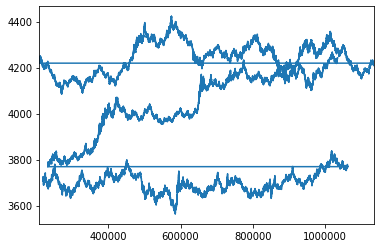

In [18]:
data['price'].plot()

In [3]:
"""
Time Bars
"""
def compute_vwap(df):
    q = df['foreignNotional']
    p = df['price']
    vwap = np.sum(p * q) / np.sum(q)
    df['vwap'] = vwap
    return df
data_timeidx = data.set_index('timestamp')
data_time_grp = data_timeidx.groupby(pd.Grouper(freq='15Min'))
num_time_bars = len(data_time_grp) # comes in handy later
data_time_vwap = data_time_grp.apply(compute_vwap)

In [4]:
data_time_vwap.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,vwap
timestamp,,,,,,,,,,
2018-11-27 00:00:03.851282,XBTUSD,Buy,10,3724.5,ZeroPlusTick,538c244f-a1a9-61db-da2e-6db7b76e7507,268490,0.002685,10.0,3714.091867
2018-11-27 00:00:04.250260,XBTUSD,Buy,20,3724.5,ZeroPlusTick,c50cf101-1c0d-445f-42c4-fc5339641968,536980,0.005370,20.0,3714.091867
2018-11-27 00:00:04.250260,XBTUSD,Buy,480,3724.5,ZeroPlusTick,b71da1f1-b76e-c1e5-59ab-765438000186,12887520,0.128875,480.0,3714.091867
2018-11-27 00:00:04.255471,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,f7741936-b74c-844b-5023-a85712fe819e,26849000,0.268490,1000.0,3714.091867
2018-11-27 00:00:04.262041,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,9f5d581b-0eef-4dcd-16a2-019488ec38b8,26849000,0.268490,1000.0,3714.091867


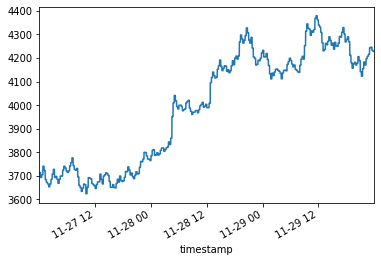

In [5]:
data_time_vwap['vwap'].plot()

In [33]:
"""
Tick Bars

The idea behind tick bars is to sample observations every N transactions, aka "ticks", instead of fixed
time buckets. This allows us to capture more information at times when many trades take place, and vice-versa.
"""
total_ticks = len(data)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = round(num_ticks_per_bar, -3) # round to the nearest thousand
data_tick_grp = data.reset_index().assign(grpId=lambda row: row.index // num_ticks_per_bar)
data_tick_vwap = data_tick_grp.groupby('grpId').apply(compute_vwap)
data_tick_vwap.set_index('timestamp', inplace=True)

In [28]:
total_ticks, num_time_bars, num_ticks_per_bar

(2577068, 288, 9000.0)

In [7]:
data_tick_vwap.head()

,index,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,grpId,vwap
timestamp,,,,,,,,,,,,
2018-11-27 00:00:03.851282,218349,XBTUSD,Buy,10,3724.5,ZeroPlusTick,538c244f-a1a9-61db-da2e-6db7b76e7507,268490,0.002685,10.0,0.0,3714.029558
2018-11-27 00:00:04.250260,218350,XBTUSD,Buy,20,3724.5,ZeroPlusTick,c50cf101-1c0d-445f-42c4-fc5339641968,536980,0.005370,20.0,0.0,3714.029558
2018-11-27 00:00:04.250260,218351,XBTUSD,Buy,480,3724.5,ZeroPlusTick,b71da1f1-b76e-c1e5-59ab-765438000186,12887520,0.128875,480.0,0.0,3714.029558
2018-11-27 00:00:04.255471,218352,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,f7741936-b74c-844b-5023-a85712fe819e,26849000,0.268490,1000.0,0.0,3714.029558
2018-11-27 00:00:04.262041,218353,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,9f5d581b-0eef-4dcd-16a2-019488ec38b8,26849000,0.268490,1000.0,0.0,3714.029558


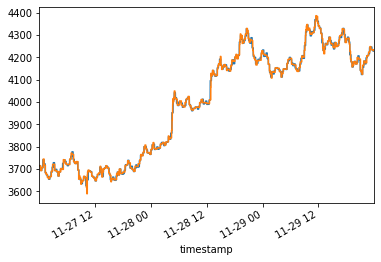

In [35]:
data_time_vwap['vwap'].plot()
data_tick_vwap['vwap'].plot()

In [36]:
"""
Volume Bars

One shortcoming of tick bars is that not all trades are equal. Consider that an order to buy 1000 contracts
is executed as one transaction, and 10 orders for 100 contracts will count for 10 transactions. It may make
sense to sample observations for every N contracts exchanged independent of how many trades took place.
"""
data_cm_vol = data.assign(cmVol=data['homeNotional'].cumsum()) 
total_vol = data_cm_vol.cmVol.values[-1]
vol_per_bar = total_vol / num_time_bars
vol_per_bar = round(vol_per_bar, -2) # round to the nearest hundred
data_vol_grp = data_cm_vol.assign(grpId=lambda row: row.cmVol // vol_per_bar)
data_vol_vwap =  data_vol_grp.groupby('grpId').apply(compute_vwap)
data_vol_vwap.set_index('timestamp', inplace=True)

In [12]:
data_vol_vwap.head()

,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,cmVol,grpId,vwap
timestamp,,,,,,,,,,,,
2018-11-27 00:00:03.851282,XBTUSD,Buy,10,3724.5,ZeroPlusTick,538c244f-a1a9-61db-da2e-6db7b76e7507,268490,0.002685,10.0,0.002685,0.0,3713.93112
2018-11-27 00:00:04.250260,XBTUSD,Buy,20,3724.5,ZeroPlusTick,c50cf101-1c0d-445f-42c4-fc5339641968,536980,0.005370,20.0,0.008055,0.0,3713.93112
2018-11-27 00:00:04.250260,XBTUSD,Buy,480,3724.5,ZeroPlusTick,b71da1f1-b76e-c1e5-59ab-765438000186,12887520,0.128875,480.0,0.136930,0.0,3713.93112
2018-11-27 00:00:04.255471,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,f7741936-b74c-844b-5023-a85712fe819e,26849000,0.268490,1000.0,0.405420,0.0,3713.93112
2018-11-27 00:00:04.262041,XBTUSD,Buy,1000,3724.5,ZeroPlusTick,9f5d581b-0eef-4dcd-16a2-019488ec38b8,26849000,0.268490,1000.0,0.673910,0.0,3713.93112


Text(0.5, 1.0, 'XBT time and volume bars')

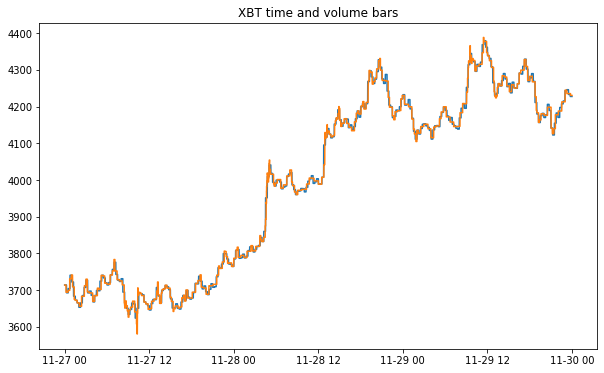

In [48]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(data_time_vwap['vwap'], label='time bars')
ax.plot(data_vol_vwap['vwap'], label='BTC volume bars')
plt.title('XBT time and volume bars')

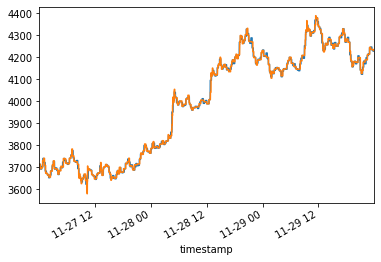

In [37]:

data_time_vwap['vwap'].plot()
data_vol_vwap['vwap'].plot()

In [ ]:
# code omitted for brevity
# same as volume bars, except using data['foreignNotional'] instead of data['homeNotional']

In [19]:
"""
Implementing Dollar Imbalance Bars
"""

'\nImplementing Dollar Imbalance Bars\n'

In [21]:
def convert_tick_direction(tick_direction):
    if tick_direction in ('PlusTick', 'ZeroPlusTick'):
        return 1
    elif tick_direction in ('MinusTick', 'ZeroMinusTick'):
        return -1
    else:
        raise ValueError('converting invalid input: '+ str(tick_direction))
data_timeidx['tickDirection'] = data_timeidx.tickDirection.map(convert_tick_direction)

ValueError: converting invalid input: 1

In [23]:
# 1.2 Compute signed flows at each tick
data_signed_flow = data_timeidx.assign(bv = data_timeidx.tickDirection * data_timeidx.size)

In [24]:
# 2. Accumulate dollar imbalance bars
from fast_ewma import _ewma
abs_Ebv_init = np.abs(data_signed_flow['bv'].mean())
E_T_init = 500000 # 500000 ticks to warm up
def compute_Ts(bvs, E_T_init, abs_Ebv_init):
    Ts, i_s = [], []
    i_prev, E_T, abs_Ebv  = 0, E_T_init, abs_Ebv_init
    
    n = bvs.shape[0]
    bvs_val = bvs.values.astype(np.float64)
    abs_thetas, thresholds = np.zeros(n), np.zeros(n)
    abs_thetas[0], cur_theta = np.abs(bvs_val[0]), bvs_val[0]
    for i in range(1, n):
        cur_theta += bvs_val[i]
        abs_theta = np.abs(cur_theta)
        abs_thetas[i] = abs_theta
        
        threshold = E_T * abs_Ebv
        thresholds[i] = threshold
        
        if abs_theta >= threshold:
            cur_theta = 0
            Ts.append(np.float64(i - i_prev))
            i_s.append(i)
            i_prev = i
            E_T = _ewma(np.array(Ts), window=np.int64(len(Ts)))[-1]
            abs_Ebv = np.abs( _ewma(bvs_val[:i], window=np.int64(E_T_init * 3))[-1] ) # window of 3 bars
    return Ts, abs_thetas, thresholds, i_s
Ts, abs_thetas, thresholds, i_s = compute_Ts(data_signed_flow.bv, E_T_init, abs_Ebv_init)

ModuleNotFoundError: No module named 'fast_ewma'

In [25]:
# Aggregate the ticks into groups based on computed boundaries
n = data_signed_flow.shape[0]
i_iter = iter(i_s + [n])
i_cur = i_iter.__next__()
grpId = np.zeros(n)
for i in range(1, n):
    if i <= i_cur:
        grpId[i] = grpId[i-1]
    else:
        grpId[i] = grpId[i-1] + 1
        i_cur = i_iter.__next__()

NameError: name 'i_s' is not defined

In [ ]:
# Putting it all together: Dollar Imbalance Bars
data_dollar_imb_grp = data_signed_flow.assign(grpId = grpId)
data_dollar_imb_vwap = data_dollar_imb_grp.groupby('grpId').apply(compute_vwap).vwap